In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%pdb

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [4]:
import opendatasets as od

od.download("https://www.kaggle.com/mohammedfarag/mitbihcsv")

Skipping, found downloaded files in ".\mitbihcsv" (use force=True to force download)


In [6]:
data_set_path=os.path.join("mitbihcsv","mit_bih_data_set.csv")

In [7]:
data_set = pd.read_csv(data_set_path,dtype=float)

https://physionet.org/content/mitdb/1.0.0/

Background

Since 1975, our laboratories at Boston's Beth Israel Hospital (now the Beth Israel Deaconess Medical Center) and at MIT have supported our own research into arrhythmia analysis and related subjects. One of the first major products of that effort was the MIT-BIH Arrhythmia Database, which we completed and began distributing in 1980. The database was the first generally available set of standard test material for evaluation of arrhythmia detectors, and has been used for that purpose as well as for basic research into cardiac dynamics at more than 500 sites worldwide. Originally, we distributed the database on 9-track half-inch digital tape at 800 and 1600 bpi, and on quarter-inch IRIG-format FM analog tape. In August, 1989, we produced a CD-ROM version of the database.

Data Description

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

In [8]:
num_classes=6

In [9]:
data_set.shape

(42020, 320)

In [6]:
data_set_np = data_set.to_numpy()

In [7]:
data_set_np.shape

(42020, 320)

In [8]:
X = data_set_np[:,:-1]

In [9]:
y = data_set_np[:,-1]

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scalar = StandardScaler()
X = scalar.fit_transform(X)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [11]:
# prepare data for keras model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

y_trn_oh = to_categorical(y_trn)
y_tst_oh = to_categorical(y_tst)

X_trn_tf = np.expand_dims(X_trn, axis=2)
X_tst_tf = np.expand_dims(X_tst, axis=2)


X_tst = X_tst.astype('float32')
X_tst_tf = X_tst_tf.astype('float32')

In [12]:
# Network
def network(X_train,y_train,X_test,y_test):
    
    model = Sequential()

    model.add(Conv1D(filters=32, kernel_size=8, activation='relu', 
                     strides=1, padding="valid",input_shape=X_train[1,:].shape,
                     name='Conv1DLayer1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=4, strides=2, padding='same'))
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', 
                     strides=1, padding="valid", name='Conv1DLayer2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=4, strides=2, padding='same'))

    model.add(Conv1D(filters=8, kernel_size=8, activation='relu', 
                     strides=1, padding="valid", name='Conv1DLayer3'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=4, strides=2, padding='same'))

    #model.add(GRU(10,return_sequences=True))
    
    model.add(Flatten())
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(num_classes, activation='softmax', name = 'OuputLayer'))
    
    opt = RMSprop(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='./best_model.h5', monitor='val_accuracy', 
                                 save_best_only=True)]

    # fit network
    history=model.fit(X_train, y_train, epochs=50,callbacks=callbacks, 
                      batch_size=500,validation_split=0.2,shuffle=True)

    model.load_weights('best_model.h5')
    return(model,history)

In [13]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4','5']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [14]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, ReLU, Dropout, GRU, LSTM, Conv1D, Input, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

model,history=network(X_trn_tf,y_trn_oh,X_tst_tf,y_tst_oh)

Epoch 1/50
54/54 [==============================] - 10s 84ms/step - loss: 1.1419 - accuracy: 0.6253 - val_loss: 1.5870 - val_accuracy: 0.5110
Epoch 2/50
54/54 [==============================] - 3s 52ms/step - loss: 0.2998 - accuracy: 0.9235 - val_loss: 1.4174 - val_accuracy: 0.5855
Epoch 3/50
54/54 [==============================] - 3s 53ms/step - loss: 0.1861 - accuracy: 0.9477 - val_loss: 1.1614 - val_accuracy: 0.7183
Epoch 4/50
54/54 [==============================] - 3s 52ms/step - loss: 0.1344 - accuracy: 0.9607 - val_loss: 0.8774 - val_accuracy: 0.7774
Epoch 5/50
54/54 [==============================] - 3s 52ms/step - loss: 0.1162 - accuracy: 0.9664 - val_loss: 0.7127 - val_accuracy: 0.8233
Epoch 6/50
54/54 [==============================] - 3s 54ms/step - loss: 0.0976 - accuracy: 0.9717 - val_loss: 0.4301 - val_accuracy: 0.9151
Epoch 7/50
54/54 [==============================] - 3s 54ms/step - loss: 0.0834 - accuracy: 0.9763 - val_loss: 0.3013 - val_accuracy: 0.9462
Epoch 8/50
5

Accuracy: 98.85%


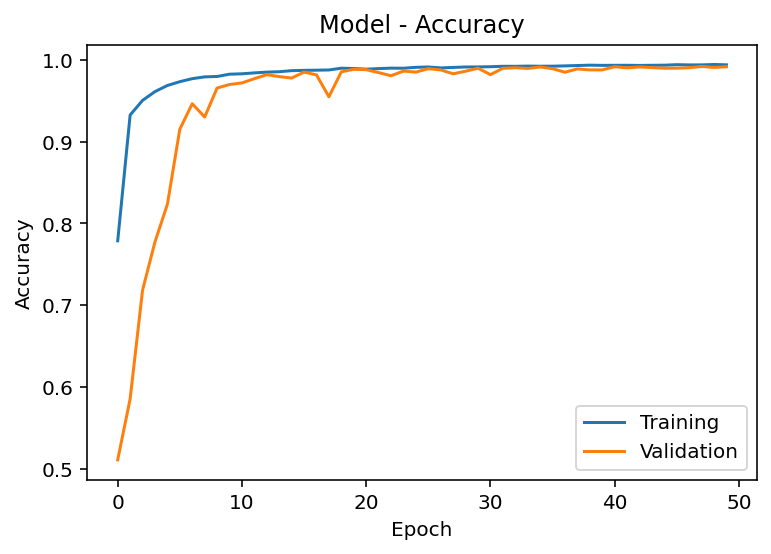

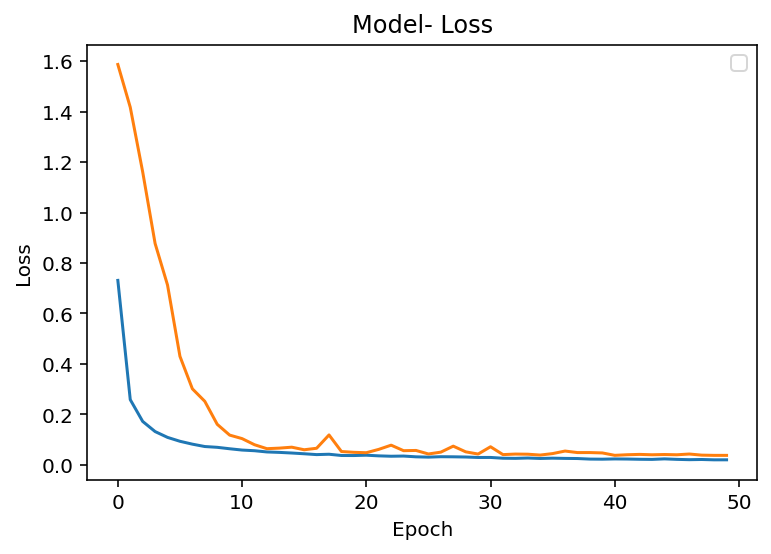

Wall time: 2.5 s


In [15]:
%%time
from sklearn.metrics import confusion_matrix

evaluate_model(history,X_tst_tf,y_tst_oh,model)
y_pred=model.predict(X_tst_tf)

Normalized confusion matrix


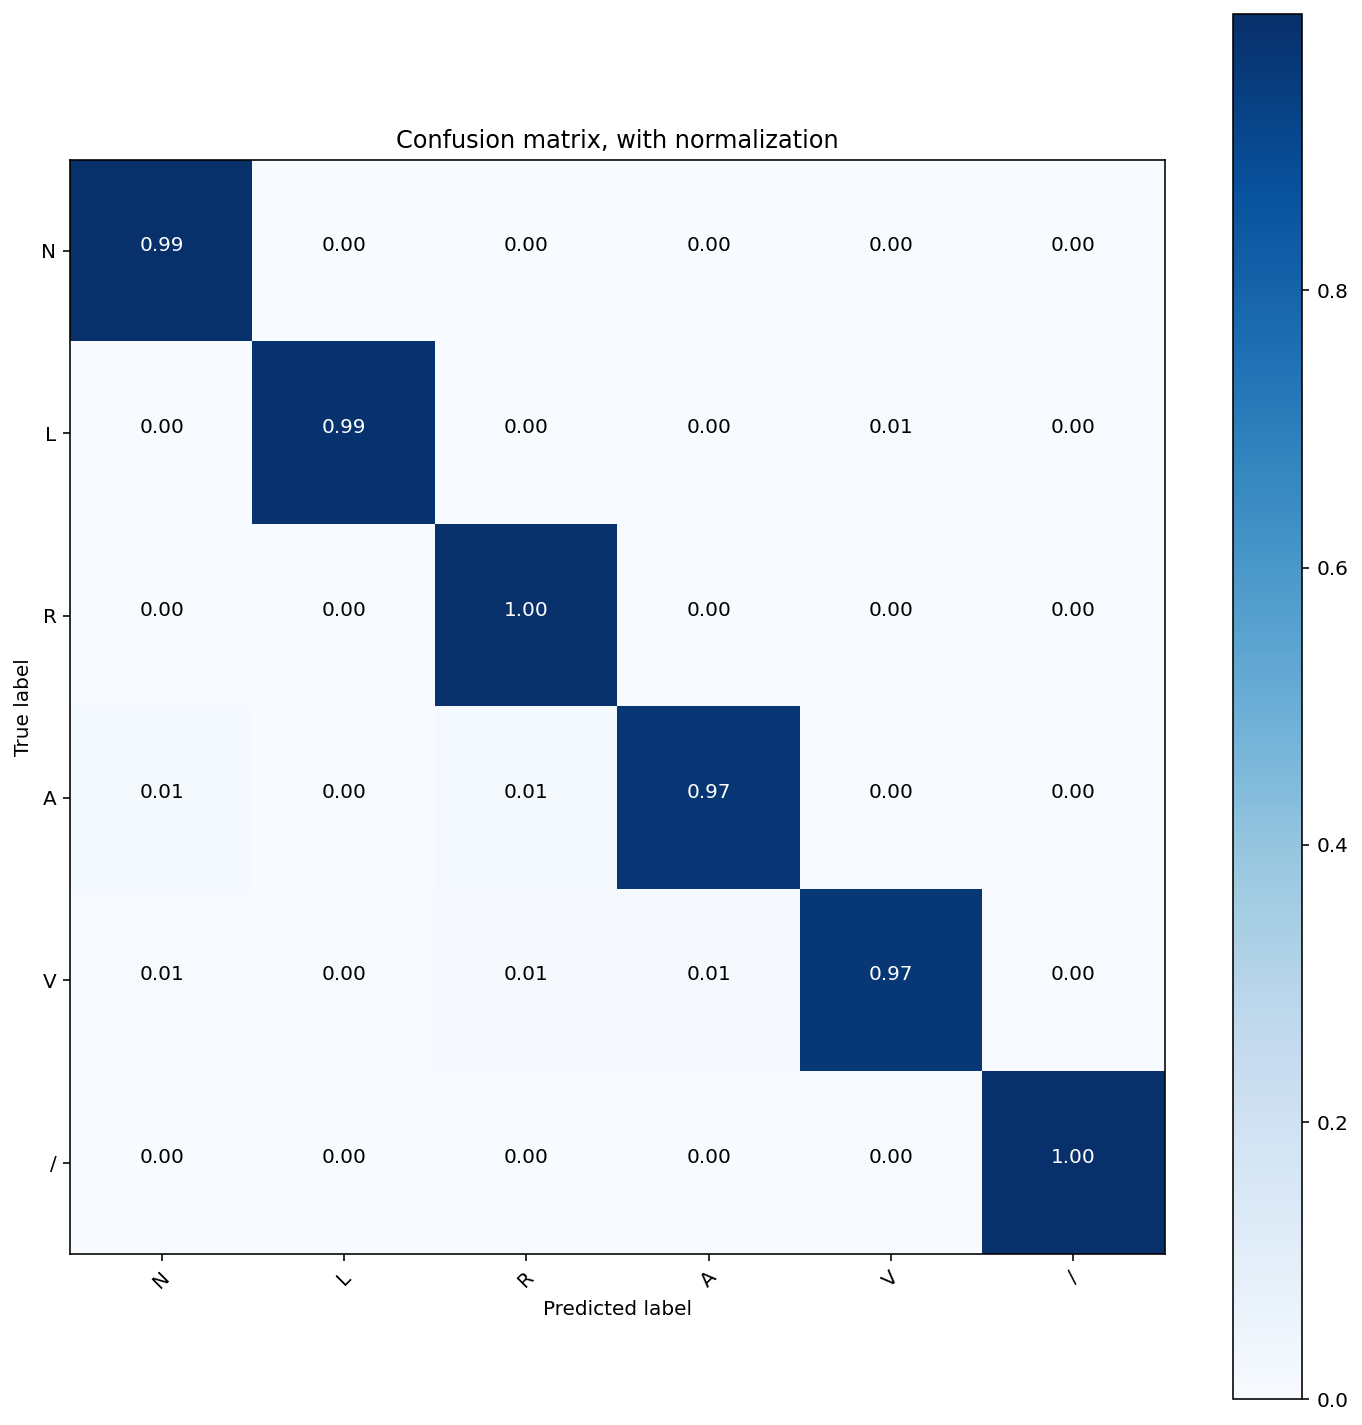

In [16]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tst_oh.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'L', 'R', 'A', 'V', '/'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()    

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1DLayer1 (Conv1D)        (None, 312, 32)           288       
_________________________________________________________________
batch_normalization (BatchNo (None, 312, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 312, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 156, 32)           0         
_________________________________________________________________
Conv1DLayer2 (Conv1D)        (None, 149, 16)           4112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 149, 16)           64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 16)           0

Accuracy: 0.9884578772013327


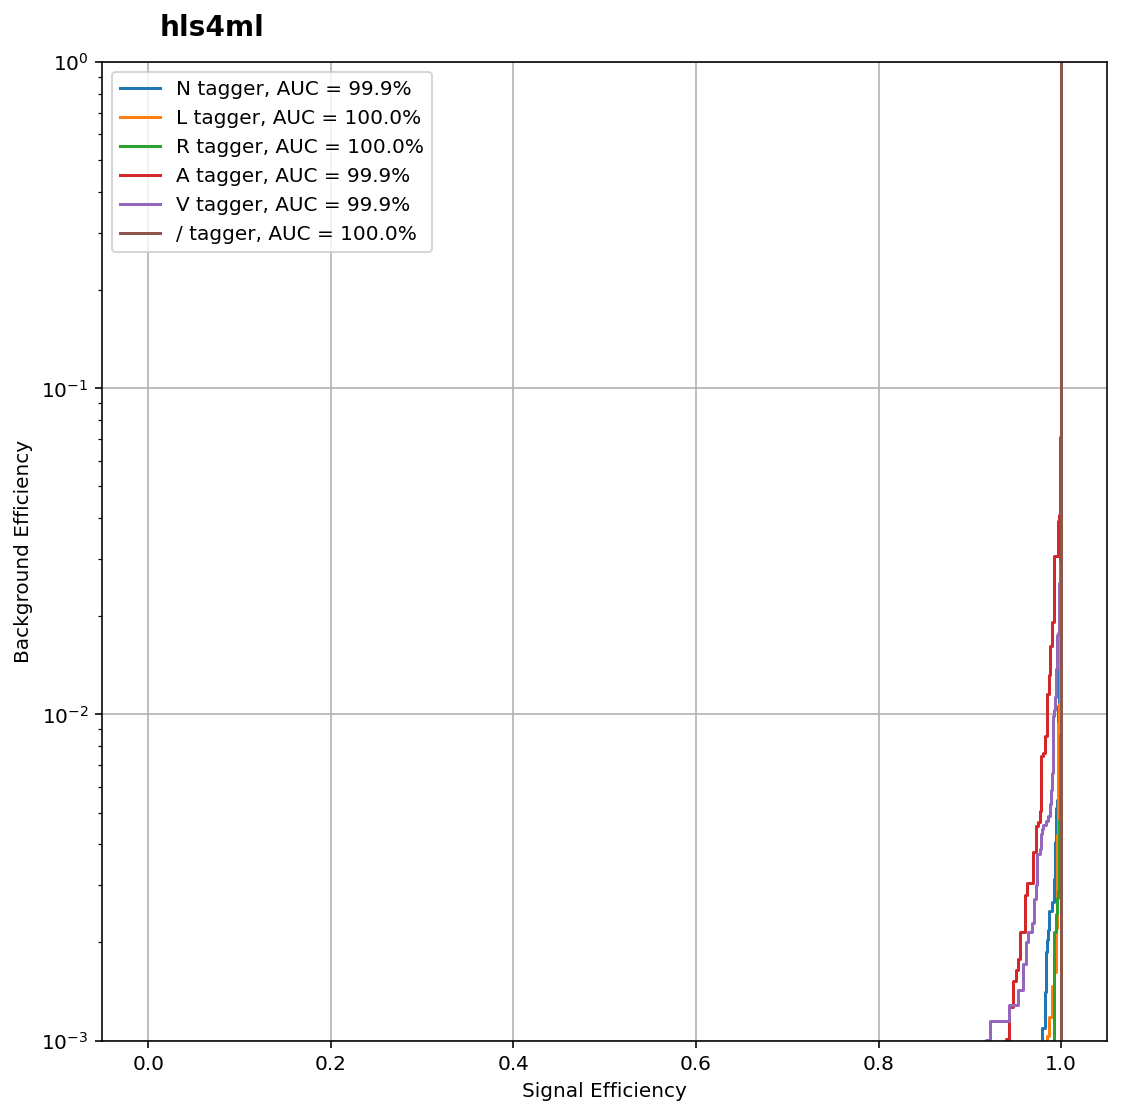

In [18]:
import plotting

from sklearn.metrics import accuracy_score

classes = ['N', 'L', 'R', 'A', 'V', '/']

y_keras = model.predict(X_tst_tf)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_tst_oh, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_tst_oh, y_keras, classes)

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = converter.convert()

float_model_size = len(float_tflite_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmp0cdy4t4b\assets
Float model size = 38KBs.


In [53]:
type(float_tflite_model)

bytes

In [20]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=float_tflite_model)
interpreter.allocate_tensors()

#get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#Preprocess the image to required size and cast
input_shape = input_details[0]['shape']
input_data = np.expand_dims(X_tst_tf[0], 0)

#set the tensor to point to the input data to be inferred
input_index = interpreter.get_input_details()[0]["index"]
interpreter.set_tensor(input_details[0]['index'], input_data)

#Run the inference
interpreter.invoke()
output_details = interpreter.get_tensor(output_details[0]['index'])

In [21]:
output_details

array([[9.63e-04, 4.27e-04, 4.37e-03, 9.89e-01, 5.51e-03, 2.10e-06]],
      dtype=float32)

In [22]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmph8lngc46\assets


INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmph8lngc46\assets


Quantized model size = 19KBs,
which is about 51% of the float model size.


In [23]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=float_tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_outputs = []
  for data in X_tst_tf:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_data = np.expand_dims(data, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_data)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    prediction = np.argmax(output()[0])
    prediction_outputs.append(prediction)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_outputs)):
    if prediction_outputs[index] == y_tst[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_outputs)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(float_tflite_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

Float model accuracy = 0.9885
Quantized model accuracy = 0.9885
Accuracy drop = 0.0000


In [24]:
# Save the quantized model to file to the Downloads directory
f = open('mit_bih.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import defaultdict

from qkeras import *

In [26]:
X_trn_tf[1,:].shape

(319, 1)

In [27]:
def CreateQModel(X_train,y_train,X_test,y_test):
    x = x_in = Input(shape = X_train[1,:].shape)
    
    x = QConv1D(filters=32, kernel_size=8, strides=1, padding="valid",
               kernel_quantizer="quantized_bits(4, 0, 1)", 
               bias_quantizer="quantized_bits(4, 0, 1)",
               name="conv1d_1")(x_in)
    x = QActivation("quantized_relu(4)", name="act_1")(x)  
    x = QBatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=4, strides=2, padding='same')(x)

    x = QConv1D(filters=16, kernel_size=8, strides=1, padding="valid",
               kernel_quantizer="quantized_bits(4, 0, 1)", 
               bias_quantizer="quantized_bits(4, 0, 1)",
               name="conv1d_2")(x)
    x = QActivation("quantized_relu(4)", name="act_2")(x)  
    x = QBatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=4, strides=2, padding='same')(x)

    x = QConv1D(filters=8, kernel_size=8, strides=1, padding="valid",
               kernel_quantizer="quantized_bits(4, 0, 1)", 
               bias_quantizer="quantized_bits(4, 0, 1)",
               name="conv1d_3")(x)
    x = QActivation("quantized_relu(4)", name="act_3")(x)  
    x = QBatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=4, strides=2, padding='same')(x)
    
    x = Flatten(name="flatten")(x)

    x = QDense(num_classes,
        kernel_quantizer="quantized_bits(4,0,1)",
        bias_quantizer="quantized_bits(4,0,1)",
        name="dense")(x)
    x = Activation("softmax", name="softmax")(x)
    
    qmodel = Model(inputs=x_in, outputs=x)
    
    opt = RMSprop(learning_rate=0.001)

    qmodel.compile(loss='categorical_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint(filepath='./best_qmodel.h5', monitor='val_accuracy', 
                                 save_best_only=True)]

    # fit network
    history=qmodel.fit(X_train, y_train, epochs=50,callbacks=callbacks, 
                      batch_size=500,validation_split=0.2,shuffle=True)

    qmodel.load_weights('best_qmodel.h5')
    return(qmodel,history)

In [28]:
qmodel,history = CreateQModel(X_trn_tf,y_trn_oh,X_tst_tf,y_tst_oh)

Epoch 1/50
54/54 [==============================] - 11s 117ms/step - loss: 1.4706 - accuracy: 0.4706 - val_loss: 1.4269 - val_accuracy: 0.4352
Epoch 2/50
54/54 [==============================] - 5s 86ms/step - loss: 0.6699 - accuracy: 0.7841 - val_loss: 0.6804 - val_accuracy: 0.7278
Epoch 3/50
54/54 [==============================] - 5s 84ms/step - loss: 0.4505 - accuracy: 0.8602 - val_loss: 0.5192 - val_accuracy: 0.8272
Epoch 4/50
54/54 [==============================] - 4s 81ms/step - loss: 0.3415 - accuracy: 0.9003 - val_loss: 0.4707 - val_accuracy: 0.8424
Epoch 5/50
54/54 [==============================] - 4s 79ms/step - loss: 0.2877 - accuracy: 0.9113 - val_loss: 0.3340 - val_accuracy: 0.8913
Epoch 6/50
54/54 [==============================] - 4s 83ms/step - loss: 0.2389 - accuracy: 0.9273 - val_loss: 0.2696 - val_accuracy: 0.9242
Epoch 7/50
54/54 [==============================] - 4s 81ms/step - loss: 0.2190 - accuracy: 0.9351 - val_loss: 0.2419 - val_accuracy: 0.9253
Epoch 8/50


In [29]:
qmodel.summary()

print_qstats(qmodel)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 319, 1)]          0         
_________________________________________________________________
conv1d_1 (QConv1D)           (None, 312, 32)           288       
_________________________________________________________________
act_1 (QActivation)          (None, 312, 32)           0         
_________________________________________________________________
q_batch_normalization (QBatc (None, 312, 32)           128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 312, 32)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 156, 32)           0         
_________________________________________________________________
conv1d_2 (QConv1D)           (None, 149, 16)           4112  

Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv1d_1                      : 79872 (smult_4_8)
    conv1d_2                      : 610304 (smult_4_4)
    conv1d_3                      : 69632 (smult_4_4)
    dense                         : 1632  (smult_4_4)

Number of operation types in model:
    smult_4_4                     : 681568
    smult_4_8                     : 79872

Weight profiling:
    conv1d_1_weights               : 256   (4-bit unit)
    conv1d_1_bias                  : 32    (4-bit unit)
    conv1d_2_weights               : 4096  (4-bit unit)
    conv1d_2_bias                  : 16    (4-bit unit)
    conv1d_3_weights               : 1024  (4-bit unit)
    conv1d_3_bias                  : 8     (4-bit unit)
    dense_weights                  : 1632  (4-bit unit)
    dense_bias                     : 6     (4-bit unit)

Weight sparsity:
... quantizing model
    conv1d_1                       : 0.1146
    conv1d_2                       : 0.1296
    conv1d_3                       

In [30]:
from qkeras.utils import *
model_save_quantized_weights(qmodel, 'qmodel.h5')
#load_qmodel('qmodel.h5', custom_objects=None, compile=True)

... quantizing model


{'conv1d_1': {'weights': [array([[[-0.25, -0.5 ,  0.5 ,  0.88, -0.62,  0.44, -0.38, -0.25,  0.44,
            -0.44,  0.44,  0.5 ,  0.12, -0.88,  0.5 ,  0.38,  0.88,  0.44,
             0.  , -0.31, -0.44, -0.5 , -0.38,  0.38, -0.5 ,  0.25,  0.12,
            -0.25, -0.44,  0.88,  0.25, -0.62]],
   
          [[-0.44, -0.25,  0.88, -0.62,  0.  , -0.44,  0.31, -0.5 ,  0.31,
            -0.44,  0.  ,  0.5 , -0.25,  0.25,  0.12, -0.5 ,  0.5 , -0.06,
             0.12,  0.  ,  0.44,  0.12, -0.25,  0.44, -0.62,  0.38, -0.38,
            -0.44,  0.38,  0.  ,  0.12,  0.25]],
   
          [[-0.31,  0.88,  0.  ,  0.25,  0.25, -0.38,  0.44,  0.5 , -0.31,
             0.44,  0.44, -0.88, -0.62,  0.62, -0.88,  0.38,  0.38, -0.44,
            -0.88, -0.44,  0.38, -0.38, -0.44,  0.44,  0.38,  0.25,  0.  ,
             0.38,  0.38, -0.75,  0.88,  0.38]],
   
          [[ 0.06,  0.88,  0.25,  0.88, -0.88, -0.12, -0.12,  0.88, -0.06,
            -0.06,  0.  , -0.12,  0.75,  0.  , -0.88, -0.12,  0.12, 

In [31]:
print_model_sparsity(qmodel)

Model Sparsity Summary (model)
--
conv1d_1: (conv1d_1/kernel:0, 0.08984375)
conv1d_2: (conv1d_2/kernel:0, 0.12890625)
conv1d_3: (conv1d_3/kernel:0, 0.138671875)
dense: (dense/kernel:0, 0.20404411764705888)




input                          -11.5861  14.6682
conv1d_1                       -47.1998  37.4535

C:\Users\mmorsy\AppData\Roaming\Python\Python38\site-packages\qkeras-0.9.0-py3.8.egg\qkeras\utils.py:994: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\mmorsy\AppData\Roaming\Python\Python38\site-packages\qkeras-0.9.0-py3.8.egg\qkeras\utils.py:1019: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


 ( -0.8750   0.8750) ( -0.2500   0.2500) a(  0.500000   1.000000)
act_1                            0.0000   0.9375
q_batch_normalization           -0.9902   7.0911 (  0.5000   1.0000) ( -0.0625   0.2500) (  0.0312   0.5000) (  0.0156   0.2500)
conv1d_2                       -32.2179  24.1948 ( -0.8750   0.8750) ( -0.3750   0.2500) a(  0.250000   0.250000)
act_2                            0.0000   0.9375
q_batch_normalization_1         -0.8730   1.8723 (  1.0000   1.0000) (  0.1250   0.5000) (  0.2500   0.5000) (  0.2500   0.2500)
conv1d_3                        -9.4911   7.7661 ( -0.8750   0.8750) ( -0.1250   0.1250) a(  0.250000   0.500000)
act_3                            0.0000   0.9375
q_batch_normalization_2         -0.4980   3.4743 (  1.0000   1.0000) (  0.2500   1.0000) (  0.1250   0.5000) (  0.0625   0.2500)
dense                          -15.3895  13.0138 ( -0.8750   0.8750) ( -0.1250   0.1250) a(  0.500000   0.500000)


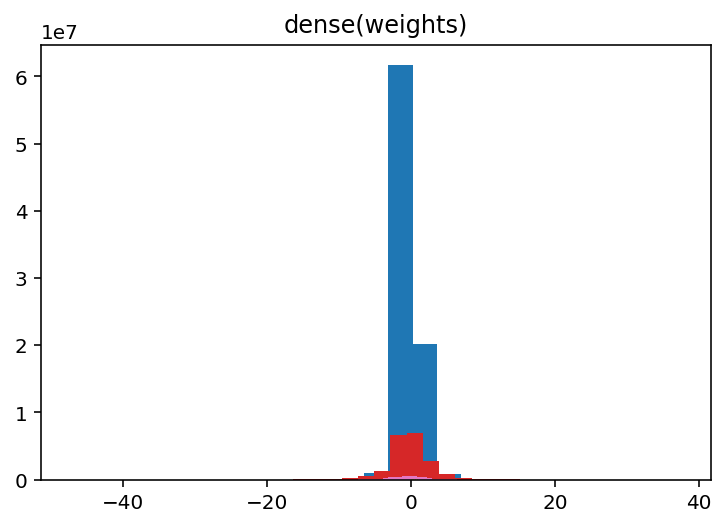

In [32]:
quantized_model_debug(qmodel, X_tst_tf, plot=True)

In [33]:
extract_model_operations(qmodel)

{'conv1d_1': {'type': ('mult', (0, 0), (4, 8), (1, 0)),
  'number_of_operations': 79872,
  'number_of_weights': 256,
  'number_of_bias': 32,
  'type_of_weights': (0, 4, 1),
  'type_of_bias': (0, 4, 1)},
 'conv1d_2': {'type': ('mult', (0, 0), (4, 4), (1, 0)),
  'number_of_operations': 610304,
  'number_of_weights': 4096,
  'number_of_bias': 16,
  'type_of_weights': (0, 4, 1),
  'type_of_bias': (0, 4, 1)},
 'conv1d_3': {'type': ('mult', (0, 0), (4, 4), (1, 0)),
  'number_of_operations': 69632,
  'number_of_weights': 1024,
  'number_of_bias': 8,
  'type_of_weights': (0, 4, 1),
  'type_of_bias': (0, 4, 1)},
 'dense': {'type': ('mult', (0, 0), (4, 4), (1, 0)),
  'number_of_operations': 1632,
  'number_of_weights': 1632,
  'number_of_bias': 6,
  'type_of_weights': (0, 4, 1),
  'type_of_bias': (0, 4, 1)}}

In [34]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(qmodel, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: C:\Users\mmorsy\AppData\Local\Temp\tmpze_7tzma.h5


In [35]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule

In [36]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 500
epochs = 50
validation_split = 0.2 # 20% of training set will be used for validation set. 

num_examples = X_trn_tf.shape[0] * (1 - validation_split)
end_step = np.ceil(num_examples / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(qmodel, **pruning_params)

opt = RMSprop(learning_rate=0.001)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_for_pruning.summary()

C:\Users\mmorsy\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 319, 1)]          0         
_________________________________________________________________
prune_low_magnitude_conv1d_1 (None, 312, 32)           546       
_________________________________________________________________
prune_low_magnitude_act_1 (P (None, 312, 32)           1         
_________________________________________________________________
prune_low_magnitude_q_batch_ (None, 312, 32)           129       
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 312, 32)           1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 156, 32)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_2 (None, 149, 16)           8210  

In [37]:
import tempfile

logdir = tempfile.mkdtemp(dir="./")

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_trn_tf, y_trn_oh,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/50
 6/54 [==>...........................] - ETA: 23s - loss: 0.0839 - accuracy: 0.9760WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0534s vs `on_train_batch_end` time: 0.3729s). Check your callbacks.


54/54 [==============================] - 18s 168ms/step - loss: 0.0812 - accuracy: 0.9750 - val_loss: 0.0771 - val_accuracy: 0.9764
Epoch 2/50
54/54 [==============================] - 5s 94ms/step - loss: 0.0797 - accuracy: 0.9743 - val_loss: 0.2931 - val_accuracy: 0.9115
Epoch 3/50
54/54 [==============================] - 6s 103ms/step - loss: 0.1311 - accuracy: 0.9579 - val_loss: 0.1514 - val_accuracy: 0.9527
Epoch 4/50
54/54 [==============================] - 6s 104ms/step - loss: 0.1112 - accuracy: 0.9653 - val_loss: 0.1618 - val_accuracy: 0.9535
Epoch 5/50
54/54 [==============================] - 5s 101ms/step - loss: 0.1101 - accuracy: 0.9657 - val_loss: 0.1201 - val_accuracy: 0.9664
Epoch 6/50
54/54 [==============================] - 5s 98ms/step - loss: 0.1038 - accuracy: 0.9676 - val_loss: 0.1082 - val_accuracy: 0.9685
Epoch 7/50
54/54 [==============================] - 5s 93ms/step - loss: 0.0927 - accuracy: 0.9703 - val_loss: 0.0981 - val_accuracy: 0.9710
Epoch 8/50
54/54 [=

In [38]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(X_tst_tf, y_tst_oh, verbose=0)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Pruned test accuracy: 0.6508805155754089


In [39]:
#!load_ext tensorboard 
#!tensorboard --logdir=logdir

In [40]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: C:\Users\mmorsy\AppData\Local\Temp\tmp69cjdpgi.h5


In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpjshtvg4g\assets


INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpjshtvg4g\assets


Saved pruned TFLite model to: C:\Users\mmorsy\AppData\Local\Temp\tmpioqbl0xj.tflite


In [42]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [43]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 10163.00 bytes
Size of gzipped pruned Keras model: 13673.00 bytes
Size of gzipped pruned TFlite model: 7822.00 bytes


In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpypc8dz5n\assets


INFO:tensorflow:Assets written to: C:\Users\mmorsy\AppData\Local\Temp\tmpypc8dz5n\assets


Saved quantized and pruned TFLite model to: C:\Users\mmorsy\AppData\Local\Temp\tmpckp1b4ha.tflite
Size of gzipped baseline Keras model: 10163.00 bytes
Size of gzipped pruned and quantized TFlite model: 7256.00 bytes


In [45]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_results = []
  for i, test_example in enumerate(X_tst_tf):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_example = np.expand_dims(test_example, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_example)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_results.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_results)
  accuracy = (prediction_results == y_tst).mean()
  return accuracy

In [46]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
print('Pruned TF test accuracy:', model_for_pruning_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.


Pruned and quantized TFLite test_accuracy: 0.6548072346501665
Pruned TF test accuracy: 0.6508805155754089
